# Bayesian Optimization

    Intelligent Hyperparameter Search with Learning-Driven Exploration

## Objective

This notebook introduces Bayesian Optimization for hyperparameter tuning, focusing on:

- Why Bayesian methods outperform grid and random search

- Sequential, model-based optimization

- Exploration vs exploitation trade-off

- Practical implementation using Optuna / skopt

- Production-ready tuning workflows

It answers:

    How do we tune complex models efficiently while learning from past evaluations?

## Why Bayesian Optimization Matters

Unlike grid or random search, Bayesian optimization:

- Learns from previous trials

- Focuses search on promising regions

- Requires far fewer evaluations

- Scales to complex models and spaces

This is the industry default for:

- Gradient boosting

- Neural networks

- High-dimensional tuning

## When to Use Bayesian Optimization

- ✔ Expensive models
- ✔ Large hyperparameter spaces
- ✔ Continuous parameters
- ✔ Limited compute
- ✔ Iterative experimentation

- ❌ Very small datasets
- ❌ Regulatory environments requiring determinism

## Conceptual Overview

Bayesian optimization:

- Builds a surrogate model (e.g., Gaussian Process, TPE)

- Uses an acquisition function (e.g., Expected Improvement)

- Selects next trial intelligently

- Updates belief after each evaluation

## Imports and Dataset

In [1]:
#   # !pip install optuna

#   #!pip install plotly

In [1]:
import numpy as np
import pandas as pd

import optuna

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [2]:
df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv")

X = df.drop(columns=["default", "customer_id"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=2010
)

## Define Objective Function

The objective returns a cross-validated score.

In [6]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    class_weight = trial.suggest_categorical(
        "class_weight", [None, "balanced"]
    )

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=C,
            penalty=penalty,
            solver="liblinear",
            max_iter=1000,
            class_weight=class_weight
        ))
    ])

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="roc_auc"
    )

    return scores.mean()


- ✔ Leakage-safe
- ✔ Cross-validated
- ✔ Optimizes business-relevant metric

# Run Optimization Study

In [9]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50)


[I 2026-02-02 11:03:59,878] A new study created in memory with name: no-name-744508f1-e60e-46b6-ad0f-0147d4cca176
[I 2026-02-02 11:03:59,949] Trial 0 finished with value: 0.916279299513677 and parameters: {'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.916279299513677.
[I 2026-02-02 11:03:59,995] Trial 1 finished with value: 0.9160022390760943 and parameters: {'C': 0.0060252157362038605, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.916279299513677.
[I 2026-02-02 11:04:00,038] Trial 2 finished with value: 0.5 and parameters: {'C': 0.001267425589893723, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.916279299513677.
[I 2026-02-02 11:04:00,082] Trial 3 finished with value: 0.9160490644085991 and parameters: {'C': 0.008260808399079604, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.916279299513677.
[I 2026-02-02 11:04:00,131] Trial 4 finished with value: 0.9159535024

50 trials ≈ hundreds of grid evaluations

## Best Parameters and Score

In [11]:
study.best_params

{'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': None}

In [12]:
study.best_value

0.916279299513677

## Train Final Model with Best Parameters

In [14]:
best_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        **study.best_params,
        solver="liblinear",
        max_iter=1000
    ))
])

best_model.fit(X_train, y_train)

y_test_prob = best_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_test_prob)


np.float64(0.9141413052215528)

## Optimization History

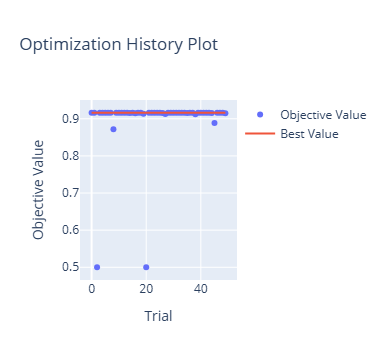

In [17]:
optuna.visualization.plot_optimization_history(study)

## Hyperparameter Importance

In [10]:
optuna.visualization.plot_param_importances(study)

 Helps reduce search space in future runs

## Exploration vs Exploitation

Key insight:

- Early trials explore

- Later trials exploit

- Convergence accelerates

## Bayesian vs Grid vs Random

| Aspect       | Grid   | Random | Bayesian  |
| ------------ | ------ | ------ | --------- |
| Efficiency   | ❌      | ⚠️     | ✔         |
| Compute      | High   | Medium | Low       |
| Learning     | ❌      | ❌      | ✔         |
| Scalability  | Poor   | Good   | Excellent |
| Industry Use | Medium | High   | Very High |



## Common Mistakes (Avoided)

- ❌ Optimizing on test set
- ❌ No CV inside objective
- ❌ Over-narrow search space
- ❌ Too few trials
- ❌ Ignoring convergence diagnostics

## Key Takeaways

- Bayesian optimization is state-of-the-art

- Learns from prior evaluations

- Requires fewer runs

- Ideal for expensive models

- Should replace grid search in most workflows

## Next Notebook
07_Model_Tuning_and_Optimization/

└── [04_early_stopping_and_pruning.ipynb](04_early_stopping_and_pruning.ipynb)
